In [1]:
import numpy as np
from tqdm import tqdm
import networkx as nx

import utils
import optimization
from social_learning import Network

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

'''
pre-setup
'''
font = {'size': 12}
matplotlib.rc('font', **font)

seed = 42
np.random.seed(seed)

times_skip = 100 # to stabilise
agent_k = 5

/Users/shumovsk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

In [3]:
'''
setup
'''
step_size = 0.1 # delta in (0, 1)
agents = 30 # number of agents
states = 2 # number of hypotheses
multistate = True # flag for non-homogeneous environment
params = 2 # number of parameters in the multinomial distribution (for likelihood)

clusters_agents = [15, 15] # cluster sizes
agents = sum(clusters_agents) # number of agents
clusters_states = [0, 1] # state of each cluster
clusters = len(clusters_agents) # number of clusters
probs = 0.1 * np.ones((clusters, clusters)) # probability matrix of size agents x agents
probs[0,0] = 0.8
probs[1,1] = 0.8
g = nx.stochastic_block_model(clusters_agents, probs, seed=0) # random graph generation
adj_matrix = nx.adjacency_matrix(g).todense() # corresponding adjacency matrix
adj_matrix = np.array(adj_matrix)

combination_matrix, centrality, connected = utils.generate_combination_weights(adj_matrix, 0) # combination matrix with uniform weights
if not connected:
    raise (ValueError, "Not connected")

state_true = [] # true state per each agent
states_c = 2
state_size = [15, 15]
for s, c in zip(list(range(states_c)), state_size):
    state_true = state_true + c*[s]
state_true = np.array(state_true)

In [32]:
def plot_kls(pos, kls):
    n = len(kls)
    for p, kl in zip(list(range(n)), kls):
        x, y = pos[p]
        plt.text(x, y + 0.1, s=str(round(kl, 3)),
                 bbox=dict(facecolor='white', alpha=0.7),
                 horizontalalignment='center', fontsize=13)
        
def plot_graph(combination_matrix, state_array, kls=None, seed=33):
    np.random.seed(seed)

    colors = sns.color_palette("tab10")
    colors_dark = sns.color_palette("dark")
    font = {'size': 17}
    matplotlib.rc('font', **font)

    combination_matrix_ = combination_matrix + combination_matrix.T
    adj_matrix = combination_matrix + combination_matrix.T
    adj_matrix[adj_matrix > 0] = 1

    pos = nx.spring_layout(nx.from_numpy_array(adj_matrix))
    G = nx.from_numpy_array(combination_matrix_)
    edges = G.edges()
    weights = [G[u][v]['weight']*5 for u, v in edges]

    fig = plt.figure(figsize=(8, 5))
    plt.box(False)

    nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors_dark[6], node_size=350)
    nodes.set_edgecolor('black')
    nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors_dark[-2], node_size=350,
                           nodelist=np.where(state_true==1)[0])
    nodes.set_edgecolor('black')
    nx.draw_networkx_edges(G, pos=pos, edge_color='black', width=weights)
    
    if kls is not None:
        plot_kls(pos, kls)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


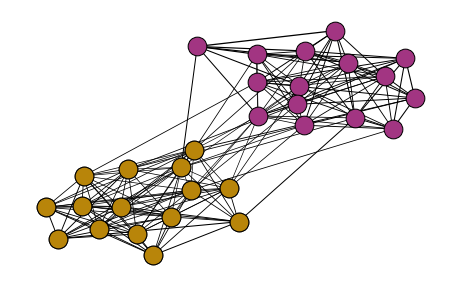

In [33]:
plot_graph(combination_matrix, state_true)

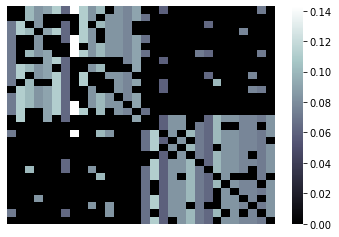

In [6]:
plt.figure()
sns.heatmap(combination_matrix, yticklabels=False, xticklabels=False, cbar=True,
            cmap=sns.color_palette("bone", as_cmap=True))
plt.show()

In [7]:
likelihood = np.array([
    [[1-0.1, 0.1], [1-0.5, 0.5]]
])
likelihood = np.repeat(likelihood, agents, 0) # agents, states, params

In [8]:
kl = utils.kl_divergence(likelihood, 0, 1, option=0, state_true=state_true)
d0, d1 = kl[0], -kl[-1]
# kl divergences per cluster
d0, d1

(0.3680642071684971, 0.5108256237659907)

In [9]:
p0 = probs[0, 0]
q = probs[0, 1]

# threhshold for delta
max((d1-d0)/d0, (d0-d1)/d1) * q/(p0-q)

0.055410136840662115

In [11]:
initial_belief = np.ones((states, agents))
initial_belief = initial_belief / initial_belief.sum(0)[None, :]
generator = utils.Generator(likelihood, state_true, 0) # random variables generator

In [14]:
times = 40000
times_skip = 100
lr = 0.01
state_0 = 0
state_1 = 1

network = Network(agents, states, state_true, adj_matrix, combination_matrix, likelihood, generator,
                  initial_belief, step_size=step_size)
network.step()

# stabilise (not necessary)
if times_skip > 0:
    for _ in range(times_skip):
        network.step()
    network = Network(agents, states, state_true, adj_matrix, combination_matrix, likelihood, generator,
                      network.belief_history[-1], step_size=step_size)
    network.step()
    
# iterations
for _ in range(times):
    network.step()

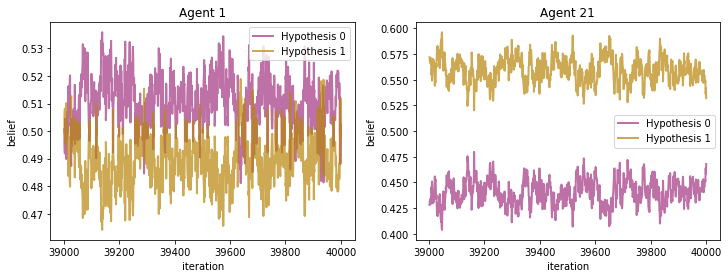

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
colors_dark = sns.color_palette("dark")
for agent, ax in zip([1, 21], axs):
    ax.title.set_text('Agent ' + str(agent))
    ax.plot(list(range(len(network.belief_history)-1000, len(network.belief_history))), np.array(network.belief_history[-1000:])[:, 0, agent],
            label='Hypothesis 0', color=colors_dark[6], linewidth=2, alpha=0.7)
    ax.plot(list(range(len(network.belief_history)-1000, len(network.belief_history))), np.array(network.belief_history[-1000:])[:, 1, agent],
            label='Hypothesis 1', color=colors_dark[-2], linewidth=2, alpha=0.7)
    ax.legend()
    ax.set_xlabel("iteration")
    ax.set_ylabel("belief")

In [23]:
# state estimate based on averaging the window
int_beliefs = [network.intermediate_belief_history[i] for i in range(-500, -1)]
int_beliefs = np.array(int_beliefs).mean(0)
state_estimate_psi = utils.state_estimate_psi(int_beliefs)
print(state_estimate_psi)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [27]:
# state estimate based on voting over the window
int_beliefs = [network.intermediate_belief_history[i] for i in range(-500, -1)]
state_estimate_psi_ = [utils.state_estimate_psi(int_belief) for int_belief in int_beliefs]
state_estimate_psi_ = np.array(state_estimate_psi_)
state_estimate_psi = []
for ag in range(state_estimate_psi_.shape[1]):
    values, counts = np.unique(state_estimate_psi_[:,ag], return_counts=True)
    state = values[np.argmax(counts)]
    state_estimate_psi.append(state)
print(np.array(state_estimate_psi))
# np.array(state_estimate_psi) == np.array(state_true)
# state_estimate_psi = utils.state_estimate_psi(int_beliefs)
# print(state_estimate_psi)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [31]:
# mc error estimation
mc_estimation = np.array([network.intermediate_belief_history[i] for i in range(-500, -1)])
mc_estimation = mc_estimation[:500,state_true,np.arange(agents)]
mc_estimation[mc_estimation >= 0.5] = 1
mc_estimation[mc_estimation < 0.5] = 0
mc_estimation = mc_estimation.mean(0)
mc_estimation = 1 - mc_estimation
print(mc_estimation)

[0.11422846 0.11422846 0.13026052 0.09418838 0.1002004  0.11823647
 0.14428858 0.14028056 0.11823647 0.13026052 0.15430862 0.14629259
 0.13226453 0.11623246 0.11222445 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


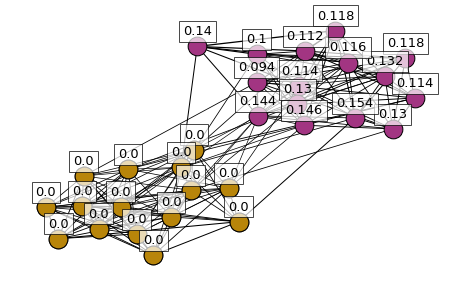

In [34]:
plot_graph(combination_matrix, state_estimate_psi, mc_estimation)

In [36]:
'''
    repeat above with different deltas
'''
# np.save('data/belief_history_{}.npy'.format(step_size), np.array(network.belief_history))

'\n    repeat above with different deltas. save arrays\n'

In [37]:
font = {'size': 14}
matplotlib.rc('font', **font)

In [79]:
runs = 500
step_sizes = [0.3, 0.1, 0.01, None]
times = 4000
times_skip = 100
lr = 0.01
window = 500
state_0 = 0
state_1 = 1

step_sizes = [None]
for step_size in step_sizes:
    step_size = step_size
    
    history = []
    for _ in tqdm(range(runs)):
        network = Network(agents, states, state_true, adj_matrix, combination_matrix, likelihood, generator,
                          initial_belief, step_size=step_size, window=times+1)
        for i in range(times):
            network.step()
        history.append(np.array(network.belief_history))
    np.save('data/belief_history_' + str(step_size) + '_100runs.npy', np.array(history))

100%|██████████| 500/500 [02:22<00:00,  3.50it/s]


In [42]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

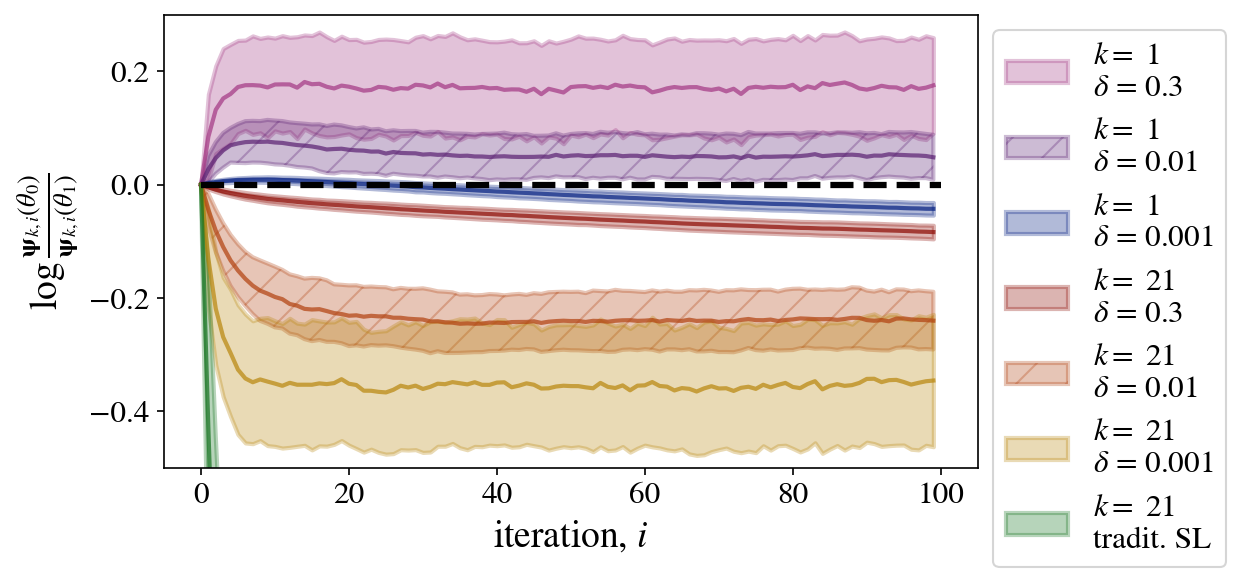

In [47]:
font = {'size': 15}
matplotlib.rc('font', **font)

bh_001 = np.load('data/belief_history_0.01_100runs.npy')
bh_01 = np.load('data/belief_history_0.1_100runs.npy')
bh_03 = np.load('data/belief_history_0.3_100runs.npy')
bh_trad = np.load('data/belief_history_None_100runs.npy')

def plot_bh(bh, T, agent, delta, color, hatch=None):
    if delta is None:
        label = '$k =$ ' + str(agent) + '\ntradit. SL'
    else:
        label = '$k =$ ' + str(agent) +'\n$\delta$ = ' + str(delta)
    logbh = np.log(bh[:, :, 0, agent]/bh[:, :, 1, agent])
    mean = np.mean(logbh, 0)[:T]
    std = np.std(logbh, 0)[:T]
    plt.plot(mean,
             color=color, linewidth=2, alpha=0.7)
    plt.fill_between(list(range(0, T)), 
                     (mean-std),
                     (mean+std),
                     label=label, 
                     color=color, linewidth=2, alpha=0.3, hatch=hatch)

plt.figure(figsize=(7, 4), dpi=150)

T = 100
agent = 1

plot_bh(bh_03, T, agent, 0.3, colors_dark[6])
plot_bh(bh_01, T, agent, 0.01, colors_dark[4], '/')
plot_bh(bh_001, T, agent, 0.001, colors_dark[0])

agent = 21
plot_bh(bh_001, T, agent, 0.3, colors_dark[3])
plot_bh(bh_01, T, agent, 0.01, colors_dark[1], '/')
plot_bh(bh_03, T, agent, 0.001, colors_dark[-2])

plot_bh(bh_trad, T, agent, None, colors_dark[2])

plt.xlabel('iteration, $i$', fontsize=18)
plt.ylabel(r'$\log \frac{\mathbf{\psi}_{k,i}(\theta_0)}{\mathbf{\psi}_{k,i}(\theta_1)}$', fontsize=18)

plt.ylim(-0.5, 0.3)
plt.hlines(xmin = 0, xmax = T, y=0, color='black', linewidth=3, linestyle='--')
plt.legend(bbox_to_anchor=(1., 1.), ncol=1)

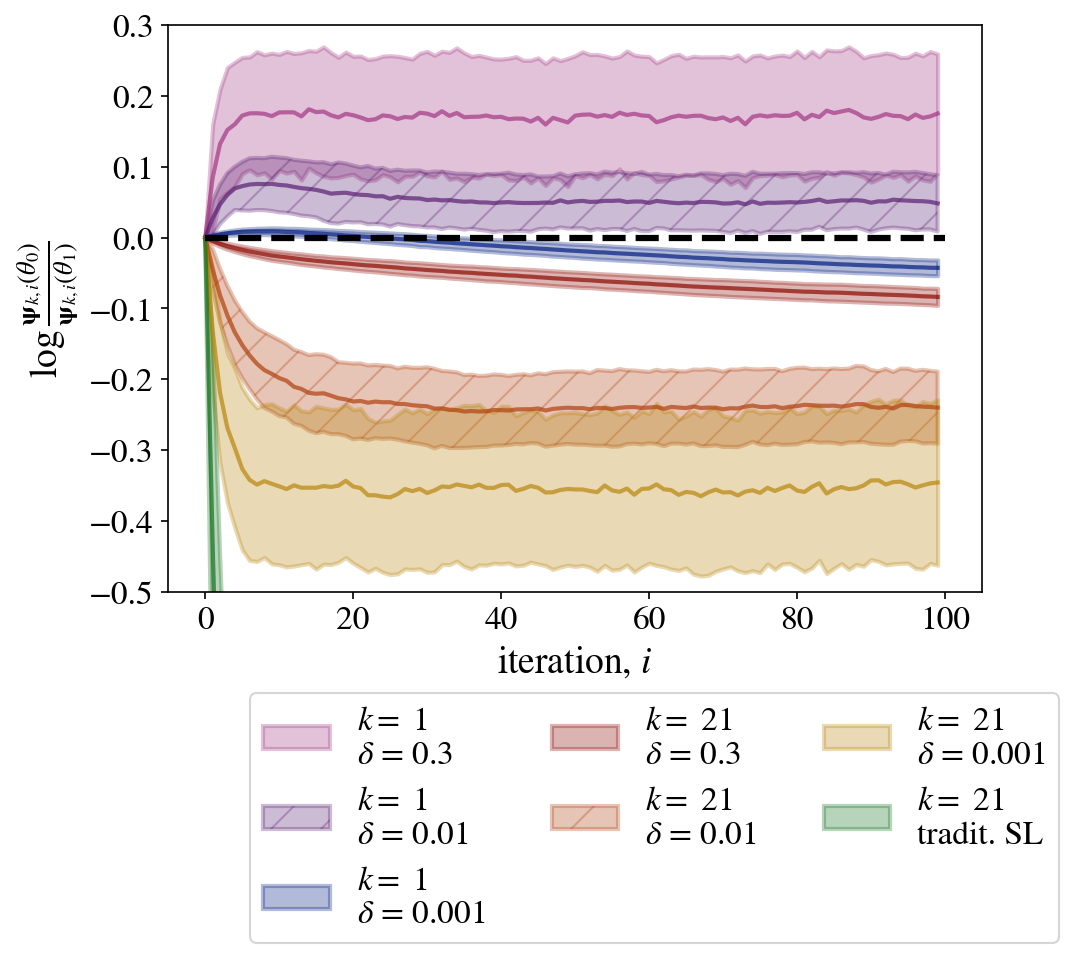

In [46]:
font = {'size': 16}
matplotlib.rc('font', **font)

bh_001 = np.load('figures_SBM/8_sbm/belief_history_0.01_100runs.npy')
bh_01 = np.load('figures_SBM/8_sbm/belief_history_0.1_100runs.npy')
bh_03 = np.load('figures_SBM/8_sbm/belief_history_0.3_100runs.npy')
bh_trad = np.load('figures_SBM/8_sbm/belief_history_None_100runs.npy')

def plot_bh(bh, T, agent, delta, color, hatch=None):
    if delta is None:
        label = '$k =$ ' + str(agent) + '\ntradit. SL'
    else:
        label = '$k =$ ' + str(agent) +'\n$\delta$ = ' + str(delta)
    logbh = np.log(bh[:, :, 0, agent]/bh[:, :, 1, agent])
    mean = np.mean(logbh, 0)[:T]
    std = np.std(logbh, 0)[:T]
    plt.plot(mean,
             color=color, linewidth=2, alpha=0.7)
    plt.fill_between(list(range(0, T)), 
                     (mean-std),
                     (mean+std),
                     label=label, 
                     color=color, linewidth=2, alpha=0.3, hatch=hatch)

plt.figure(figsize=(7, 5), dpi=150)

T = 100
agent = 1

plot_bh(bh_03, T, agent, 0.3, colors_dark[6])
plot_bh(bh_01, T, agent, 0.01, colors_dark[4], '/')
plot_bh(bh_001, T, agent, 0.001, colors_dark[0])

agent = 21
plot_bh(bh_001, T, agent, 0.3, colors_dark[3])
plot_bh(bh_01, T, agent, 0.01, colors_dark[1], '/')
plot_bh(bh_03, T, agent, 0.001, colors_dark[-2])

plot_bh(bh_trad, T, agent, None, colors_dark[2])

plt.xlabel('iteration, $i$', fontsize=18)
plt.ylabel(r'$\log \frac{\mathbf{\psi}_{k,i}(\theta_0)}{\mathbf{\psi}_{k,i}(\theta_1)}$', fontsize=18)

plt.ylim(-0.5, 0.3)
plt.hlines(xmin = 0, xmax = T, y=0, color='black', linewidth=3, linestyle='--')
plt.legend(bbox_to_anchor=(0.08, -0.15), ncol=3)